## Disclaimer

This notebook is just me playing around with Corona data for my own entertainment. It is neither rigorous nor objective, and probably not very elegant, either. Please do not take any of these results for authoritative! Thank you :)

## Predicting Corona Cases by Nox Pollution

Corona cases are commonly modelled with a logistic model:

$$ n(t) = \alpha n(t) \left(1 - \frac{n(t)}{K} \right) $$

Where $n(t)$ is the number of infections at time $t$, $\alpha$ is the growth rate, and $K$ is the maximum number of people that can get infected.
Since 22.03.2020 a curfew has been put in place in Bavaria. Additionally, people were asked to pay increased attention to hygiene and keep a safety distance to others. These measures have had an effect on $\alpha$, which means that $\alpha$ is now itself time-dependent:

$$ n(t) = \alpha(t) n(t) \left(1 - \frac{n(t)}{K} \right) $$

On Copernicus Hub, ESA makes data from the Sentinel 5P mission available, which measures $NO_x$ pollution in the atmosphere. If this data correlates with human transportation, it can be used to account for the effects of the curfew - the less travel, the more people adhere to the curfew. 

Let's assume we can calculate a measure of _connectivity_ $C_{x, y, t}$ between location $x$ and $y$ at time $t$ from the $NO_x$ data. ($C_{x, y, t}$ depends on $t$ because with the curfew people will travel less). Then we can explicitly integrate this connectivity in our growth formula:

$$ n(x, t) = \alpha(t) \left( \sum_y C_{y, x, t} n(y, t) \right) \left(1 - \frac{n(x, t)}{K} \right) $$

Note here that $C_{x, x, t}$ stands for the connectivity within a Landkreis, i.e. traffic within a city/region, probably consisting of commuting, shopping etc. 

As an interesting side effect, with transportation explicitly accounted for, all changes to $\alpha$ must stem from the remaining measures, hygiene and social distancing.


### 0. Preparing data

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.optimize as scpo
import shapely as sply

In [3]:
shps = gpd.read_file('./data/landkreise_risklayer.geojson')
shps = shps.rename(columns={'type': 'art', 'ags': 'AGS'})
shps['AGS'] = shps['AGS'].astype(np.int64)
vals = pd.read_csv('./data/values_landkreise_0904_no_ka.csv')

data = pd.merge(shps, vals, left_on='AGS', right_on='AGS', how='left')
data = data.set_index('name')

dateColNames = data.columns[6:-2]

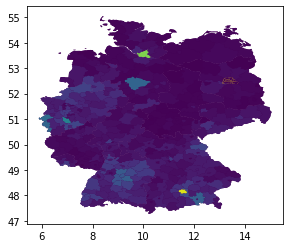

In [4]:
data.plot(column='current')

Judging from the video there is clearly a spatial component to the spread of the virus

In [5]:
bundeslaender = data[data.art == 'bundesland']
landkreise = data[data.art == 'landkreis']
landkreise[dateColNames] = landkreise[dateColNames].astype(np.int64)
bundeslaender[dateColNames] = landkreise.groupby('partof')[dateColNames].sum()
landkreise.current = landkreise.current.astype(np.int64)
bundeslaender.current = landkreise.groupby('partof').current.sum()

In [6]:
laenderNames = bundeslaender.index
laenderIds = np.arange(len(laenderNames))
bayernCuml = bundeslaender.loc['Bayern']
KBayern = bayernCuml['population']

We will focus only on Bavaria for now, because we have the exact date when the curfew was put into action there (22.03.2020).

In [7]:
landkreiseBayern = landkreise[landkreise.partof == 'Bayern']
landkreisNamesBayern = landkreiseBayern.index
landkreisIdsBayern = np.arange(len(landkreisNamesBayern))
populationBayern = landkreiseBayern['population'].values
KsBayern = landkreiseBayern['population']
T = len(dateColNames)
time = np.arange(T)
incubationTime = 7
tCurfew = list(dateColNames.values).index('22.03.2020')
tCurfewEffect = tCurfew + incubationTime

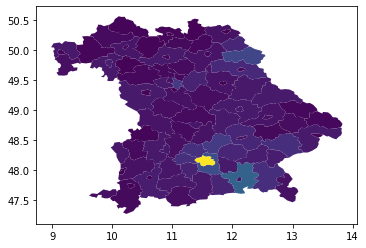

In [8]:
landkreiseBayern.plot(column='current')

### 1. Simple model

As a sanity check, let's first fit an ordinary logistic model to our data.

In [9]:
def simpleModelBayern(alpha):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [10]:
def mseBayern(paras, model):
    y = bayernCuml[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [11]:
resultsSimpleBayern = scpo.minimize(mseBayern, x0=[1.0], bounds=((0.01, 5.0),), args=(simpleModelBayern,))
resultsSimpleBayern

      fun: 18782150.470354203
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.09781933])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 5
   status: 0
  success: True
        x: array([0.19251171])

In [12]:
def plotSim(mod, paras):
    y = bayernCuml[dateColNames].values
    ySim = mod(*paras)
    plt.scatter(time, y)
    plt.plot(time, ySim)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

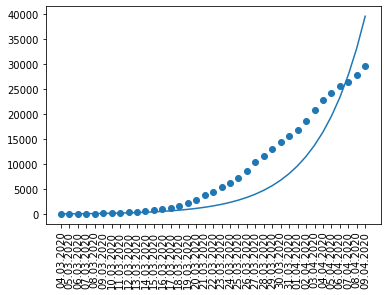

In [13]:
plotSim(simpleModelBayern, (resultsSimpleBayern.x,))

There is no closed form estimator for $\alpha$ in the logistic formula, be we can get a decent approximation with the mean differences over all values:

In [14]:
def estimateAlpha(values, K):
    nt = values[:-1]
    nt1 = values[1:]
    alpha = np.mean((nt1 - nt) * (K/(K-nt)) * (1/nt))
    return alpha

estimateAlpha(bayernCuml[dateColNames].values, KBayern)

0.18753996181292948

### 2. Allowing step in $\alpha$

In [15]:
def stepModelBayern(alpha0, alpha1):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [16]:
resultsStepBayern = scpo.minimize(mseBayern, x0=[1.0, 1.0], bounds=((0.01, 5.0), (0.01, 5.0)), args=(stepModelBayern,))
resultsStepBayern

      fun: 524695.8277719732
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.3865141 , -0.17462298])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 189
      nit: 21
   status: 0
  success: True
        x: array([0.23779335, 0.06941015])

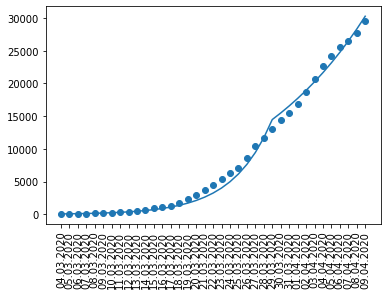

In [17]:
plotSim(stepModelBayern, resultsStepBayern.x)

Let's try to recreate our findings with an estimated $\alpha$, instead of optimization:

In [18]:
dateColNamesBeforeTcurfew = dateColNames[:tCurfewEffect]
estimateAlpha(bayernCuml[dateColNamesBeforeTcurfew].values, KBayern)

0.24079758935072157

In [19]:
dateColNamesAfterTcurfew = dateColNames[tCurfewEffect:]
estimateAlpha(bayernCuml[dateColNamesAfterTcurfew].values, KBayern)

0.07732294077121259

Again, this is comming decently close to the optimized values.

### 3. Spatial model  (with toy-connectivity)

First, we need to calculate $C_{x, y, t}$. 
In the next section we'll use ESA's $NO_x$ data from Sentinel 5P, but as a simple stand-in, let's for now just assume that Landkreise have some connectivity $n$ if they are neighbours.

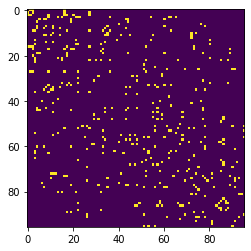

In [20]:
L = len(landkreisNamesBayern)
neighbours = np.zeros((L, L), dtype=bool)
for x in range(L):
    for y in range(x, L):
        lkName1 = landkreiseBayern.index[x]
        lkName2 = landkreiseBayern.index[y]
        lk1 = landkreiseBayern.loc[lkName1]
        lk2 = landkreiseBayern.loc[lkName2]
        if lk1.geometry.touches(lk2.geometry):
            neighbours[x, y] = True
            neighbours[y, x] = True

plt.imshow(neighbours)

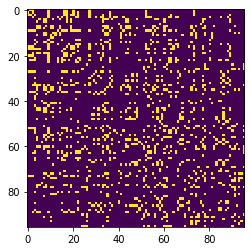

In [21]:
neighbours2ndDegree = neighbours.dot(neighbours) - np.eye(len(landkreisIdsBayern))
plt.imshow(neighbours2ndDegree)

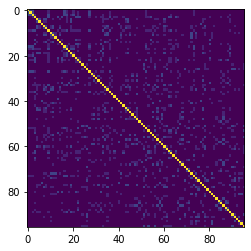

In [22]:
def calcConnectivity(n):
    L = len(landkreisNamesBayern)
    connectivity = np.zeros((L, L), dtype=np.float64)
    for x in range(L):
        for y in range(x, L):
            if x == y:
                c = 1
            elif neighbours[x, y]:
                c = n
            elif neighbours2ndDegree[x, y]:
                c = n / 2
            else:
                c = 0.0
            connectivity[x, y] = c
            connectivity[y, x] = c
    return connectivity

tc = calcConnectivity(0.2)
plt.imshow(tc)

We can now make use of that connectivity in our model. Remember that $C_{x, y, t}$ is supposed to be time-dependent. In this simplified example, we just assume that $C$ is reduced globally by some factor $m$ once the curfew is implemented. We'll make this more detailed once we work with actual $NO_x$ data.

In [23]:
def spatialModel(alpha0, alpha1, n, m):
    """
        alpha0: infectivity before curfew
        alpha1: infectivity after curfew
        n: fraction connection to neighbors
        m: fraction of traffic after curfew
    """
    
    connectivity0 = calcConnectivity(n)
    connectivity1 = m * connectivity0
    
    infected = np.zeros((len(landkreisIdsBayern), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values

    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        connectivity = connectivity0 if t < tCurfew else connectivity1
        
        n_t = infected[:, t]
        n_w = connectivity.dot(n_t)
        dndt = alpha * n_w * (1 - n_t / KsBayern)
        infected[:, t+1] = n_t + dndt

    return infected

In [24]:
def plotSimLks(mod, paras, lkNames):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    for lkName in lkNames:
        i = list(landkreiseBayern.index).index(lkName)
        plt.scatter(time, y[i])
        plt.plot(time, ySim[i], label=lkName)
    plt.legend()
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

In [25]:
def plotSimLksRelative(mod, paras, lkNames):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    for lkName in lkNames:
        i = list(landkreiseBayern.index).index(lkName)
        pop = populationBayern[i]
        plt.scatter(time, 1000 * y[i] / pop)
        plt.plot(time, 1000 * ySim[i] / pop, label=lkName)
    plt.legend()
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

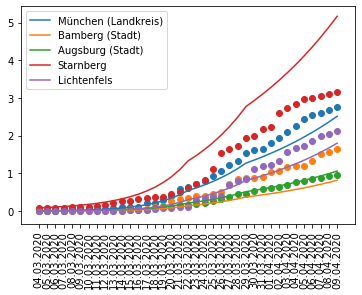

In [34]:
# Doing a testplot to find a good starting point
startParas = [0.1, 0.05, 0.15, 0.5]
plotSimLksRelative(spatialModel, startParas, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

In [35]:
def mseSpatial(paras, model):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim)**2)
    return me

def mseSpatialRelative(paras, model):
    # mseSpatial might give extra weight to large cities. This method normalizes all errors by population.
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    populationBayernRs = populationBayern.reshape(len(populationBayern), 1)
    y_p = (y / populationBayernRs) * 10000
    y_sim_p = (y_sim / populationBayernRs) * 10000
    me = np.mean((y_p - y_sim_p) ** 2)
    return me

In [36]:
def wrapHistory(objectiveFunction, history):
    def wrapped(*args):
        v = objectiveFunction(*args)
        history.append({'args': args, 'val': v})
        return v
    return wrapped

In [37]:
historySpatial = []
resultsSpatial = scpo.minimize(wrapHistory(mseSpatialRelative, historySpatial), x0=startParas, bounds=((0.001, .5), (0.001, .5), (0.001, 0.3), (0.01, 0.99)), args=(spatialModel,))
resultsSpatial

      fun: 62.94127951274656
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-34.31258762,  21.88274664,  -6.94285873,   0.08078942])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 30
   status: 0
  success: True
        x: array([0.06184029, 0.03357828, 0.24651614, 0.66991368])

In [38]:
def scatterHistory(hist, p1, p2, filterFunc, l1, l2, cmapName='viridis'):
    xs = []
    ys = []
    zs = []
    for e in hist:
        if filterFunc(e):
            xs.append(e['args'][0][p1])
            ys.append(e['args'][0][p2])
            zs.append(e['val'])
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    img = ax.scatter(xs, ys, c=zs, cmap=plt.get_cmap(cmapName))
    ax.set_xlabel(l1)
    ax.set_ylabel(l2)
    legend1 = ax.legend(*img.legend_elements(),
                    loc="lower left")
    ax.add_artist(legend1)


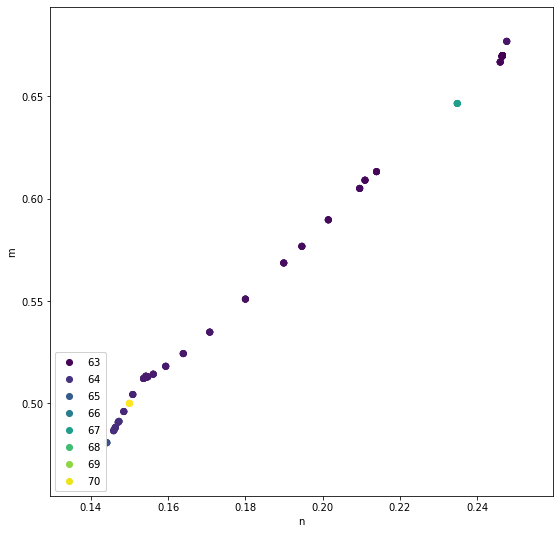

In [39]:
scatterHistory(historySpatial, 2, 3, lambda e: e['val'] < 80, 'n', 'm')

With this scatter plot we try to check if the  optimization algorithm has traced out a reasonable path through parameter space. It is especially good to see, that points seem to have an ok spread across the $n / m$ plane, which makes us moderately confident that we are not just stuck in a local minimum.

Let's look at how this model does for some Landkreise and globally.

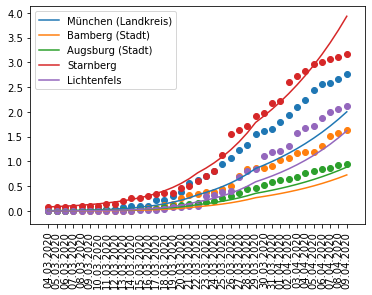

In [40]:
plotSimLksRelative(spatialModel, resultsSpatial.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

The model seems to overestimate some and underestimate other LKs.

In [41]:
def plotSimLksCuml(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    y_cuml = np.sum(y, axis=0)
    y_sim_cuml = np.sum(y_sim, axis=0)
    plt.scatter(time, y_cuml)
    plt.plot(time, y_sim_cuml)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

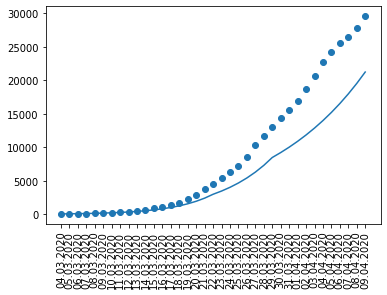

In [42]:
plotSimLksCuml(spatialModel, resultsSpatial.x)

The spatial model seems ok, but it often underestimates the real case numbers.

In [43]:
def plotLocalDifferences(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(y)
    axes[0].set_title('data')
    axes[1].imshow((y - y_sim)**2)
    axes[1].set_title('SE')
    axes[2].imshow(y_sim)
    axes[2].set_title('simulation')
    axes[0].set_ylabel('landkreis')
    axes[0].set_xlabel('t')
    axes[1].set_xlabel('t')
    axes[2].set_xlabel('t')


def plotLocalDifferencesRelative(model, paras):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    populationBayernRs = populationBayern.reshape(len(populationBayern), 1)
    y_p = (y / populationBayernRs) * 10000
    y_sim_p = (y_sim / populationBayernRs) * 10000
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(y_p)
    axes[0].set_title('data')
    axes[1].imshow((y_p - y_sim_p)**2)
    axes[1].set_title('SE')
    axes[2].imshow(y_sim_p)
    axes[2].set_title('simulation')
    axes[0].set_ylabel('landkreis')
    axes[0].set_xlabel('t')
    axes[1].set_xlabel('t')
    axes[2].set_xlabel('t')

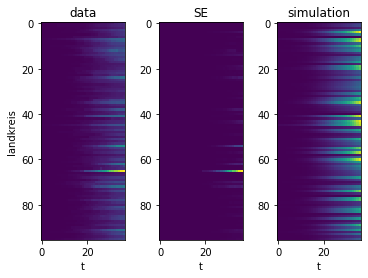

In [44]:
plotLocalDifferencesRelative(spatialModel, resultsSpatial.x)

It's not surprising that the estimation error goes up with time.

Let's try to find out what factors cause the biggest errors. Maybe we make bigger errors for larger cities?

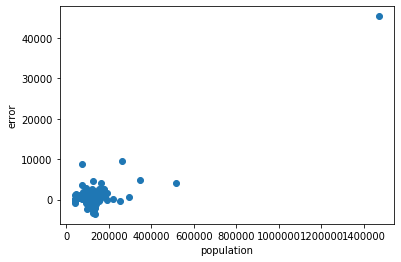

In [45]:
def plotErrorVsX(model, paras, columnName):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    err = np.sum(y - y_sim, axis=1)
    x = landkreiseBayern[columnName].values
    plt.scatter(x, err)
    plt.xlabel(columnName)
    plt.ylabel('error')

plotErrorVsX(spatialModel, resultsSpatial.x, 'population')


No, there does not seem to be a clear relationship between population and error. Also note that there are more positive than negative errors, confirming that our model does indeed systematically underestimate growth.

### 5. Spatial model with toy-connectivity using local estimates for $\alpha$

Maybe the problem lies with our assumption that there is a global value for $\alpha$ that holds in all LKs. We'll create a model that fits a local estimate for $\alpha$ to each LK to see if that makes the model more precise.

In [46]:
def estimateSpatialAlphas(values, Ks, connectivity):
    values[values == 0] = 1  # for numeric reasons
    n_t = values[:, :-1]
    n_t1 = values[:, 1:]
    L, T = n_t.shape
    n_w = connectivity.dot(n_t)
    K_sq = np.repeat([Ks], T, axis=0).T
    invFracFree = K_sq / (K_sq - n_t)
    alphas_t = invFracFree * (n_t1 - n_t) / n_w
    alphas = np.mean(alphas_t, axis=1)
    return alphas


In [47]:
def spatialModelLocal(n, m):
    """
        n: fraction connection to neighbors
        m: fraction of traffic after curfew
    """

    infectedMeasured = landkreiseBayern[dateColNames].values
    infectedMeasuredBefore = infectedMeasured[:, :tCurfewEffect]
    infectedMeasuredAfter = infectedMeasured[:, tCurfewEffect:]

    connectivity0 = calcConnectivity(n)
    connectivity1 = m * connectivity0
    alphas0 = estimateSpatialAlphas(infectedMeasuredBefore, KsBayern, connectivity0)
    alphas1 = estimateSpatialAlphas(infectedMeasuredAfter, KsBayern, connectivity1) 

    infected = np.zeros((len(landkreisIdsBayern), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values

    for t in range(T-1):
        alphas = alphas0 if t < tCurfewEffect else alphas1
        connectivity = connectivity0 if t < tCurfew else connectivity1

        n_t = infected[:, t]
        n_w = connectivity.dot(n_t)
        dndt = alphas * n_w * (1 - n_t / KsBayern)
        infected[:, t+1] = n_t + dndt
    
    return infected

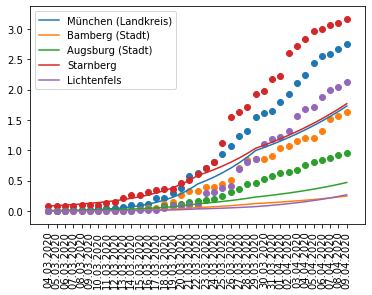

In [63]:
# Doing a testplot to find a good starting point
startParasLocal = [0.1, 0.5]
plotSimLksRelative(spatialModelLocal, startParasLocal, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

In [49]:
historySpatialLocal = []
resultsSpatialLocal = scpo.minimize(wrapHistory(mseSpatialRelative, historySpatialLocal), x0=startParasLocal, bounds=((0.001, 0.5), (0.001, 0.99)), args=(spatialModelLocal,))
resultsSpatialLocal

      fun: 40.72944272668905
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.42108547e-06, -5.71339648e+01])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 8
   status: 0
  success: True
        x: array([0.11801105, 0.99      ])

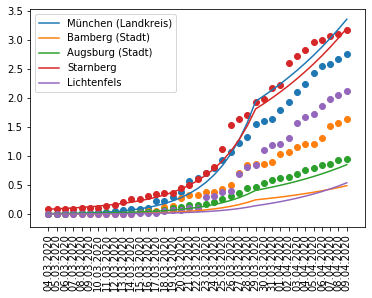

In [50]:
plotSimLksRelative(spatialModelLocal, resultsSpatialLocal.x, ['München (Landkreis)', 'Bamberg (Stadt)', 'Augsburg (Stadt)', 'Starnberg', 'Lichtenfels'])

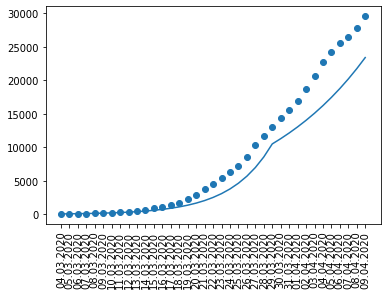

In [51]:
plotSimLksCuml(spatialModelLocal, resultsSpatialLocal.x)

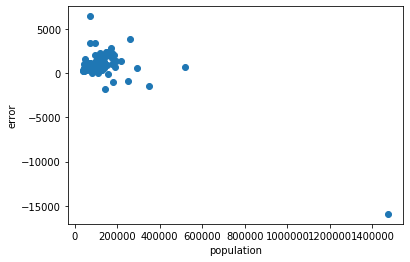

In [52]:
plotErrorVsX(spatialModelLocal, resultsSpatialLocal.x, 'population')

In [53]:
n_est, m_est = resultsSpatialLocal.x

infectedMeasured = landkreiseBayern[dateColNames].values
infectedMeasuredBefore = infectedMeasured[:, :tCurfewEffect]
infectedMeasuredAfter = infectedMeasured[:, tCurfewEffect:]

connectivity0 = calcConnectivity(n_est)
connectivity1 = m_est * connectivity0
alphas0 = estimateSpatialAlphas(infectedMeasuredBefore, KsBayern, connectivity0)
alphas1 = estimateSpatialAlphas(infectedMeasuredAfter, KsBayern, connectivity1)

landkreiseBayern['alpha0'] = alphas0
landkreiseBayern['alpha1'] = alphas1
landkreiseBayern['delta_alpha'] = landkreiseBayern['alpha0'] - landkreiseBayern['alpha1']

Text(0.5, 1, 'difference')

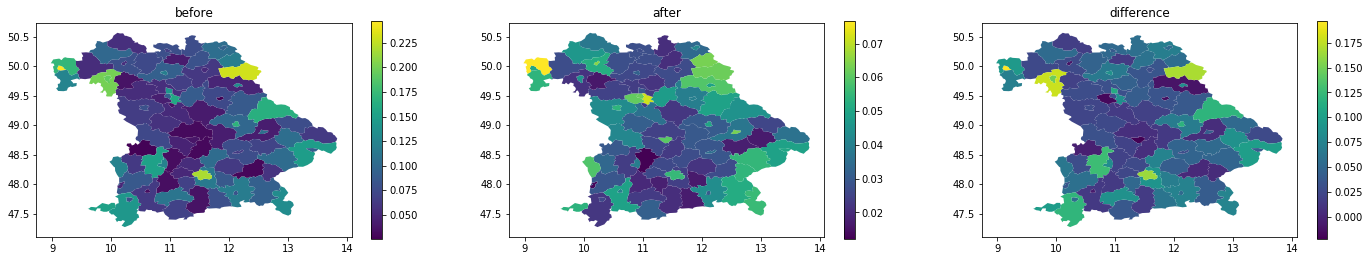

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(24, 4))
landkreiseBayern.plot(column='alpha0', axes=axes[0], legend=True)
landkreiseBayern.plot(column='alpha1', axes=axes[1], legend=True)
landkreiseBayern.plot(column='delta_alpha', axes=axes[2], legend=True)
axes[0].set_title('before')
axes[1].set_title('after')
axes[2].set_title('difference')


Text(0.5, 1.0, 'after')

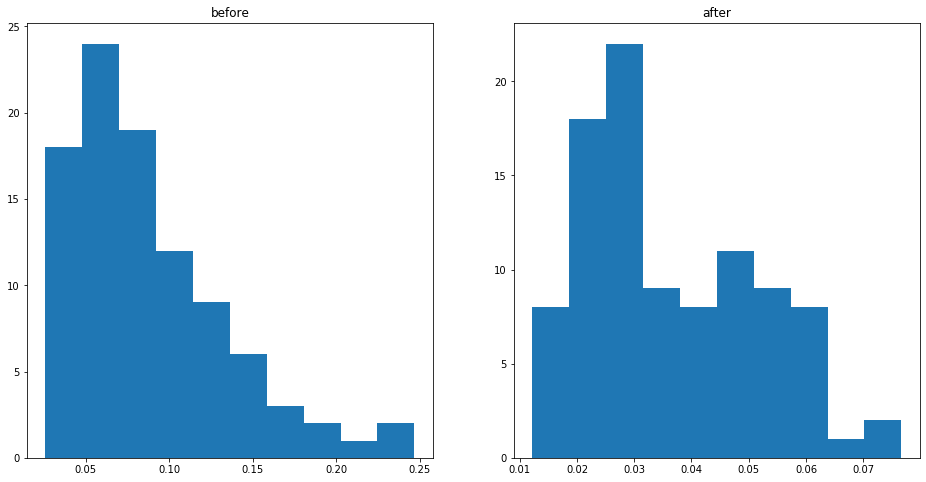

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].hist(alphas0)
axes[0].set_title('before')
axes[1].hist(alphas1)
axes[1].set_title('after')

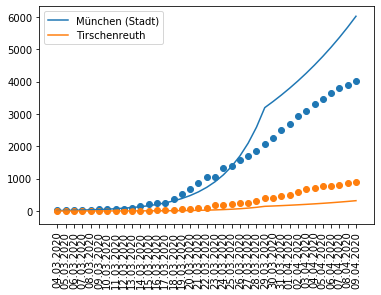

In [56]:
plotSimLks(spatialModelLocal, resultsSpatialLocal.x, ['München (Stadt)', 'Tirschenreuth'])